In [1]:
import os
import torch
import torch.nn as nn
from PIL import Image
from PIL import ImageOps
from src.training import fit
import torchinfo as torchinfo
from src.evaluation import evaluate_model
from collections import Counter
from torchvision import datasets, transforms
from src.training import plot_train_results_from_json
from torchvision.models import inception_v3, Inception_V3_Weights
from torch.utils.data import DataLoader, WeightedRandomSampler

# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# Path de descarga de datasets usando KaggleHub
os.environ["KAGGLEHUB_CACHE"] = "./"

# PARAMETROS GLOBALES
BATCH_SIZE = 256
WORKERS = 0
DATASET_AUGMENTED_SIZE = 4000

print(f'Dispositivo a utilizar: {device}')

Dispositivo a utilizar: cuda


In [2]:
# Directorio raíz del dataset
root_dir = "./data/dataset"

# Inicializamos contador
channel_counter = Counter()
errors = []

# Recorremos todas las imágenes
for split in ["train", "valid", "test"]:
    split_path = os.path.join(root_dir, split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    channel_counter[img.mode] += 1
            except Exception as e:
                errors.append((img_path, str(e)))

# Resultados
print("Cantidad de imágenes por tipo de canal (modo):")
for mode, count in channel_counter.items():
    print(f"  {mode}: {count} imágenes")

if errors:
    print("\n⚠️ Errores al abrir algunas imágenes:")
    for path, err in errors:
        print(f"  {path} -> {err}")

Cantidad de imágenes por tipo de canal (modo):
  RGBA: 923 imágenes
  RGB: 74 imágenes
  L: 3 imágenes


In [3]:
class ResizeWithAspectRatioPadding:
    """
    Clase para redimensionar imágenes manteniendo el aspecto y rellenando con ceros (padding).
    """
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        # Convertimos a tamaño cuadrado manteniendo aspecto
        old_width, old_height = img.size
        ratio = min(self.target_size[0] / old_width, self.target_size[1] / old_height)
        new_size = (int(old_width * ratio), int(old_height * ratio))
        img = img.resize(new_size, resample=Image.BILINEAR)

        delta_w = self.target_size[0] - new_size[0]
        delta_h = self.target_size[1] - new_size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = ImageOps.expand(img, padding, fill=0)

        return img

In [4]:
# Paso previo obligatorio: transformar todo a RGB
to_rgb = transforms.Lambda(lambda img: img.convert("RGB"))

# Tamaño objetivo (input para ResNet)
image_size = (299, 299)

# 1- Se aplican distintas transformaciones para el dataset de train y test
# Transform para train (con augmentations)
train_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Augmentations suaves
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform para valid (sin augmentations, con resize)
valid_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform para test (idéntico a valid)
test_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2- Se cargan los datasets de train y test con las transformaciones
train_dataset = datasets.ImageFolder(root='data/dataset' + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='data/dataset' + '/test', transform=test_transform)
valid_dataset = datasets.ImageFolder(root='data/dataset' + '/valid', transform=valid_transform)

# 3- Se splitea el dataset de train en train y validation para entrenamiento, test se deja para tarea final de evaluación
# Obtener las etiquetas de las imágenes en el dataset de entrenamiento
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
class_weights = {cls: len(targets) / count for cls, count in class_counts.items()}
sample_weights = torch.DoubleTensor([class_weights[label] for label in targets])

# 4 - Sampler balanceado
sampler = WeightedRandomSampler(
    weights=sample_weights,num_samples=DATASET_AUGMENTED_SIZE,replacement=True
)

# 5 - DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=WORKERS, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

# 6 - Info
print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de train dataset original: {len(train_dataset)}")
print(f"Tamaño de train dataset con augmentation: {DATASET_AUGMENTED_SIZE}")
print(f"Tamaño de validation dataset: {len(valid_dataset)}")
print(f"Tamaño de test dataset: {len(test_dataset)}")

Pesos por clase: {0: 3.1435897435897435, 1: 5.3304347826086955, 2: 4.141891891891892, 3: 3.9548387096774196}
Tamaño de train dataset original: 613
Tamaño de train dataset con augmentation: 4000
Tamaño de validation dataset: 72
Tamaño de test dataset: 315


In [5]:
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights)
print(f'La arquitectura por default de ResNet-50 es la siguiente:\n\n{model}') 

La arquitectura por default de ResNet-50 es la siguiente:

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicC

In [6]:
torchinfo.summary(model, input_size=(1, 3, 224, 224), depth=3, col_names=["kernel_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
Inception3                               --                        [1, 1000]                 3,326,696
├─BasicConv2d: 1-1                       --                        [1, 32, 111, 111]         --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 32, 111, 111]         864
│    └─BatchNorm2d: 2-2                  --                        [1, 32, 111, 111]         64
├─BasicConv2d: 1-2                       --                        [1, 32, 109, 109]         --
│    └─Conv2d: 2-3                       [3, 3]                    [1, 32, 109, 109]         9,216
│    └─BatchNorm2d: 2-4                  --                        [1, 32, 109, 109]         64
├─BasicConv2d: 1-3                       --                        [1, 64, 109, 109]         --
│    └─Conv2d: 2-5                       [3, 3]                    [1, 64, 109, 109]         18,432
│    └─BatchNorm2d: 

In [7]:
def build_inceptionv3_transfer(num_classes: int = 4) -> nn.Module:
    model = inception_v3(weights=Inception_V3_Weights.DEFAULT)

    # Reemplazar la capa fully connected final
    in_features = model.fc.in_features
    aux_in_features = model.AuxLogits.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

    # Congelar todos los parámetros
    for param in model.parameters():
        param.requires_grad = False

    # Descongelar solo la nueva fc
    for param in model.fc.parameters():
        param.requires_grad = True
    for param in model.AuxLogits.fc.parameters():
        param.requires_grad = True

    return model

def build_inceptionv3_finetune(num_classes: int = 4) -> nn.Module:
    model = inception_v3(weights=Inception_V3_Weights.DEFAULT)

    # Reemplazar la capa fully connected final
    in_features = model.fc.in_features
    aux_in_features = model.AuxLogits.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

    # Congelar todo menos layer4 y fc
    for name, param in model.named_parameters():
        if any(layer in name for layer in ["Mixed_7", "fc", "AuxLogits"]):
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model

In [8]:
model = build_inceptionv3_transfer(num_classes=4)

# Verificación
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Entrenando: {name}")

Entrenando: AuxLogits.fc.weight
Entrenando: AuxLogits.fc.bias
Entrenando: fc.weight
Entrenando: fc.bias


In [9]:
fit(model, train_loader=train_loader, eval_loader=val_loader, epochs=100, model_name='data/inceptionv3_fc_weights.pth', results_file='data/inceptionv3_fc_train_results.json') 

val_loss 1.24161 val_acc 0.33333: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch 1/100 loss 1.67058 val_loss 1.24161 acc 0.42725 val_acc 0.33333 train_f1 0.42030 val_f1 0.33044
Mejor modelo guardado en la época 1 con val_loss 1.24161
Mejor modelo guardado.


val_loss 1.18294 val_acc 0.37500: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 2/100 loss 1.24391 val_loss 1.18294 acc 0.64902 val_acc 0.37500 train_f1 0.63931 val_f1 0.34401
Mejor modelo guardado en la época 2 con val_loss 1.18294
Mejor modelo guardado.


val_loss 1.07716 val_acc 0.48611: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch 3/100 loss 1.06532 val_loss 1.07716 acc 0.71475 val_acc 0.48611 train_f1 0.70915 val_f1 0.44107
Mejor modelo guardado en la época 3 con val_loss 1.07716
Mejor modelo guardado.


val_loss 0.94215 val_acc 0.55556: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch 4/100 loss 0.97880 val_loss 0.94215 acc 0.71343 val_acc 0.55556 train_f1 0.70591 val_f1 0.54153
Mejor modelo guardado en la época 4 con val_loss 0.94215
Mejor modelo guardado.


val_loss 0.91530 val_acc 0.56944: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch 5/100 loss 0.91317 val_loss 0.91530 acc 0.74282 val_acc 0.56944 train_f1 0.73834 val_f1 0.55737
Mejor modelo guardado en la época 5 con val_loss 0.91530
Mejor modelo guardado.


val_loss 0.91263 val_acc 0.54167: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch 6/100 loss 0.84633 val_loss 0.91263 acc 0.76411 val_acc 0.54167 train_f1 0.76064 val_f1 0.52638
Mejor modelo guardado en la época 6 con val_loss 0.91263
Mejor modelo guardado.


val_loss 0.91066 val_acc 0.52778: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch 7/100 loss 0.81040 val_loss 0.91066 acc 0.76670 val_acc 0.52778 train_f1 0.76468 val_f1 0.52002
Mejor modelo guardado en la época 7 con val_loss 0.91066
Mejor modelo guardado.


val_loss 0.89422 val_acc 0.56944: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch 8/100 loss 0.77523 val_loss 0.89422 acc 0.77144 val_acc 0.56944 train_f1 0.76894 val_f1 0.56342
Mejor modelo guardado en la época 8 con val_loss 0.89422
Mejor modelo guardado.


val_loss 0.90240 val_acc 0.56944: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch 9/100 loss 0.76119 val_loss 0.90240 acc 0.77305 val_acc 0.56944 train_f1 0.77209 val_f1 0.55762


val_loss 0.91182 val_acc 0.56944: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch 10/100 loss 0.72861 val_loss 0.91182 acc 0.78047 val_acc 0.56944 train_f1 0.77861 val_f1 0.55312


val_loss 0.86720 val_acc 0.56944: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch 11/100 loss 0.71251 val_loss 0.86720 acc 0.78911 val_acc 0.56944 train_f1 0.78618 val_f1 0.56898
Mejor modelo guardado en la época 11 con val_loss 0.86720
Mejor modelo guardado.


val_loss 0.85476 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch 12/100 loss 0.70292 val_loss 0.85476 acc 0.79341 val_acc 0.62500 train_f1 0.78996 val_f1 0.62138
Mejor modelo guardado en la época 12 con val_loss 0.85476
Mejor modelo guardado.


val_loss 0.85337 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch 13/100 loss 0.67064 val_loss 0.85337 acc 0.80557 val_acc 0.62500 train_f1 0.80409 val_f1 0.62284
Mejor modelo guardado en la época 13 con val_loss 0.85337
Mejor modelo guardado.


val_loss 0.86306 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch 14/100 loss 0.66610 val_loss 0.86306 acc 0.80322 val_acc 0.59722 train_f1 0.80321 val_f1 0.59312


val_loss 0.86865 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch 15/100 loss 0.64585 val_loss 0.86865 acc 0.80957 val_acc 0.59722 train_f1 0.80744 val_f1 0.59811


val_loss 0.85749 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 16/100 loss 0.61925 val_loss 0.85749 acc 0.81108 val_acc 0.59722 train_f1 0.80921 val_f1 0.59272


val_loss 0.84401 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 17/100 loss 0.62016 val_loss 0.84401 acc 0.81616 val_acc 0.59722 train_f1 0.81571 val_f1 0.59581
Mejor modelo guardado en la época 17 con val_loss 0.84401
Mejor modelo guardado.


val_loss 0.84504 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 18/100 loss 0.59088 val_loss 0.84504 acc 0.82695 val_acc 0.63889 train_f1 0.82499 val_f1 0.63966


val_loss 0.85300 val_acc 0.58333: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Epoch 19/100 loss 0.61636 val_loss 0.85300 acc 0.81084 val_acc 0.58333 train_f1 0.80973 val_f1 0.58457


val_loss 0.85357 val_acc 0.58333: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch 20/100 loss 0.58021 val_loss 0.85357 acc 0.82305 val_acc 0.58333 train_f1 0.82281 val_f1 0.57965


val_loss 0.84488 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch 21/100 loss 0.57422 val_loss 0.84488 acc 0.82056 val_acc 0.59722 train_f1 0.81934 val_f1 0.59661


val_loss 0.83837 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 22/100 loss 0.57494 val_loss 0.83837 acc 0.81963 val_acc 0.59722 train_f1 0.81916 val_f1 0.59491
Mejor modelo guardado en la época 22 con val_loss 0.83837
Mejor modelo guardado.


val_loss 0.83229 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 23/100 loss 0.56013 val_loss 0.83229 acc 0.82832 val_acc 0.62500 train_f1 0.82800 val_f1 0.62280
Mejor modelo guardado en la época 23 con val_loss 0.83229
Mejor modelo guardado.


val_loss 0.84918 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch 24/100 loss 0.56086 val_loss 0.84918 acc 0.82998 val_acc 0.62500 train_f1 0.82772 val_f1 0.61975


val_loss 0.83538 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch 25/100 loss 0.57932 val_loss 0.83538 acc 0.80688 val_acc 0.59722 train_f1 0.80565 val_f1 0.59272


val_loss 0.88833 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch 26/100 loss 0.55845 val_loss 0.88833 acc 0.82271 val_acc 0.61111 train_f1 0.82086 val_f1 0.59482


val_loss 0.84918 val_acc 0.58333: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch 27/100 loss 0.57479 val_loss 0.84918 acc 0.81348 val_acc 0.58333 train_f1 0.80980 val_f1 0.58244


val_loss 0.83309 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 28/100 loss 0.54938 val_loss 0.83309 acc 0.82114 val_acc 0.62500 train_f1 0.81927 val_f1 0.61956


val_loss 0.82804 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 29/100 loss 0.53125 val_loss 0.82804 acc 0.83169 val_acc 0.62500 train_f1 0.83082 val_f1 0.62247
Mejor modelo guardado en la época 29 con val_loss 0.82804
Mejor modelo guardado.


val_loss 0.81655 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 30/100 loss 0.51871 val_loss 0.81655 acc 0.84097 val_acc 0.62500 train_f1 0.84001 val_f1 0.62274
Mejor modelo guardado en la época 30 con val_loss 0.81655
Mejor modelo guardado.


val_loss 0.81734 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch 31/100 loss 0.53989 val_loss 0.81734 acc 0.83389 val_acc 0.62500 train_f1 0.83364 val_f1 0.62188


val_loss 0.82156 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 32/100 loss 0.50611 val_loss 0.82156 acc 0.84141 val_acc 0.63889 train_f1 0.84203 val_f1 0.63602


val_loss 0.82712 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch 33/100 loss 0.52071 val_loss 0.82712 acc 0.83687 val_acc 0.61111 train_f1 0.83663 val_f1 0.60946


val_loss 0.82921 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch 34/100 loss 0.53336 val_loss 0.82921 acc 0.82446 val_acc 0.62500 train_f1 0.82290 val_f1 0.62242


val_loss 0.80421 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch 35/100 loss 0.51145 val_loss 0.80421 acc 0.83306 val_acc 0.63889 train_f1 0.83232 val_f1 0.63872
Mejor modelo guardado en la época 35 con val_loss 0.80421
Mejor modelo guardado.


val_loss 0.85198 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch 36/100 loss 0.51307 val_loss 0.85198 acc 0.83599 val_acc 0.62500 train_f1 0.83488 val_f1 0.62280


val_loss 0.83163 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch 37/100 loss 0.51192 val_loss 0.83163 acc 0.82876 val_acc 0.61111 train_f1 0.82711 val_f1 0.60509


val_loss 0.86842 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch 38/100 loss 0.52279 val_loss 0.86842 acc 0.82402 val_acc 0.62500 train_f1 0.82444 val_f1 0.62096


val_loss 0.82443 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch 39/100 loss 0.50940 val_loss 0.82443 acc 0.83774 val_acc 0.63889 train_f1 0.83552 val_f1 0.63987


val_loss 0.83270 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch 40/100 loss 0.52295 val_loss 0.83270 acc 0.82378 val_acc 0.61111 train_f1 0.82305 val_f1 0.60546


val_loss 0.80055 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 41/100 loss 0.51143 val_loss 0.80055 acc 0.84038 val_acc 0.63889 train_f1 0.84008 val_f1 0.64090
Mejor modelo guardado en la época 41 con val_loss 0.80055
Mejor modelo guardado.


val_loss 0.82101 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch 42/100 loss 0.50818 val_loss 0.82101 acc 0.83599 val_acc 0.63889 train_f1 0.83468 val_f1 0.63927


val_loss 0.78942 val_acc 0.65278: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch 43/100 loss 0.50052 val_loss 0.78942 acc 0.82822 val_acc 0.65278 train_f1 0.82787 val_f1 0.65121
Mejor modelo guardado en la época 43 con val_loss 0.78942
Mejor modelo guardado.


val_loss 0.79336 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch 44/100 loss 0.51522 val_loss 0.79336 acc 0.82910 val_acc 0.62500 train_f1 0.82816 val_f1 0.62539


val_loss 0.81536 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch 45/100 loss 0.47799 val_loss 0.81536 acc 0.84438 val_acc 0.61111 train_f1 0.84361 val_f1 0.60639


val_loss 0.80383 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch 46/100 loss 0.49562 val_loss 0.80383 acc 0.83188 val_acc 0.61111 train_f1 0.83149 val_f1 0.60953


val_loss 0.82073 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch 47/100 loss 0.46573 val_loss 0.82073 acc 0.84502 val_acc 0.62500 train_f1 0.84497 val_f1 0.62503


val_loss 0.79800 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch 48/100 loss 0.49756 val_loss 0.79800 acc 0.83218 val_acc 0.62500 train_f1 0.83069 val_f1 0.62575


val_loss 0.79944 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 49/100 loss 0.48824 val_loss 0.79944 acc 0.83843 val_acc 0.63889 train_f1 0.83894 val_f1 0.63643


val_loss 0.81039 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 50/100 loss 0.46319 val_loss 0.81039 acc 0.84502 val_acc 0.63889 train_f1 0.84518 val_f1 0.63872


val_loss 0.82474 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch 51/100 loss 0.47936 val_loss 0.82474 acc 0.84033 val_acc 0.63889 train_f1 0.84033 val_f1 0.64259


val_loss 0.85043 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch 52/100 loss 0.48201 val_loss 0.85043 acc 0.83750 val_acc 0.63889 train_f1 0.83606 val_f1 0.63835


val_loss 0.87355 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch 53/100 loss 0.49142 val_loss 0.87355 acc 0.83169 val_acc 0.63889 train_f1 0.83208 val_f1 0.63471


val_loss 0.81884 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch 54/100 loss 0.49271 val_loss 0.81884 acc 0.83765 val_acc 0.63889 train_f1 0.83737 val_f1 0.64090


val_loss 0.84252 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

Epoch 55/100 loss 0.47290 val_loss 0.84252 acc 0.84185 val_acc 0.62500 train_f1 0.84193 val_f1 0.61778
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([1.670576386153698,
  1.2439084872603416,
  1.0653160475194454,
  0.978804811835289,
  0.9131663478910923,
  0.8463309854269028,
  0.8103997148573399,
  0.7752310112118721,
  0.7611939795315266,
  0.7286140471696854,
  0.7125085555016994,
  0.7029230892658234,
  0.6706366091966629,
  0.66610112413764,
  0.6458526067435741,
  0.6192511692643166,
  0.6201576739549637,
  0.5908787250518799,
  0.6163617596030235,
  0.5802101083099842,
  0.5742184557020664,
  0.5749361105263233,
  0.5601318925619125,
  0.5608578603714705,
  0.5793212726712227,
  0.5584543161094189,
  0.5747927110642195,
  0.5493842288851738,
  0.5312538258731365,
  0.5187093615531921,
  0.5398915521800518,
  0.5061090476810932,
  0.520713210105896,
  0.5333641432225704,
  0.5114536639302969,
  0.5130722355097532,
  0.5119244866073132,
  0.5227871965616941,
  0.5093980897217989,
  0.5229518730193377,
  0.5114305093884468,
  0.5081839263439178,
  0.5005153752863407,
  0.5152244307100773,
  0.4779887776821852,
  0.49561798013

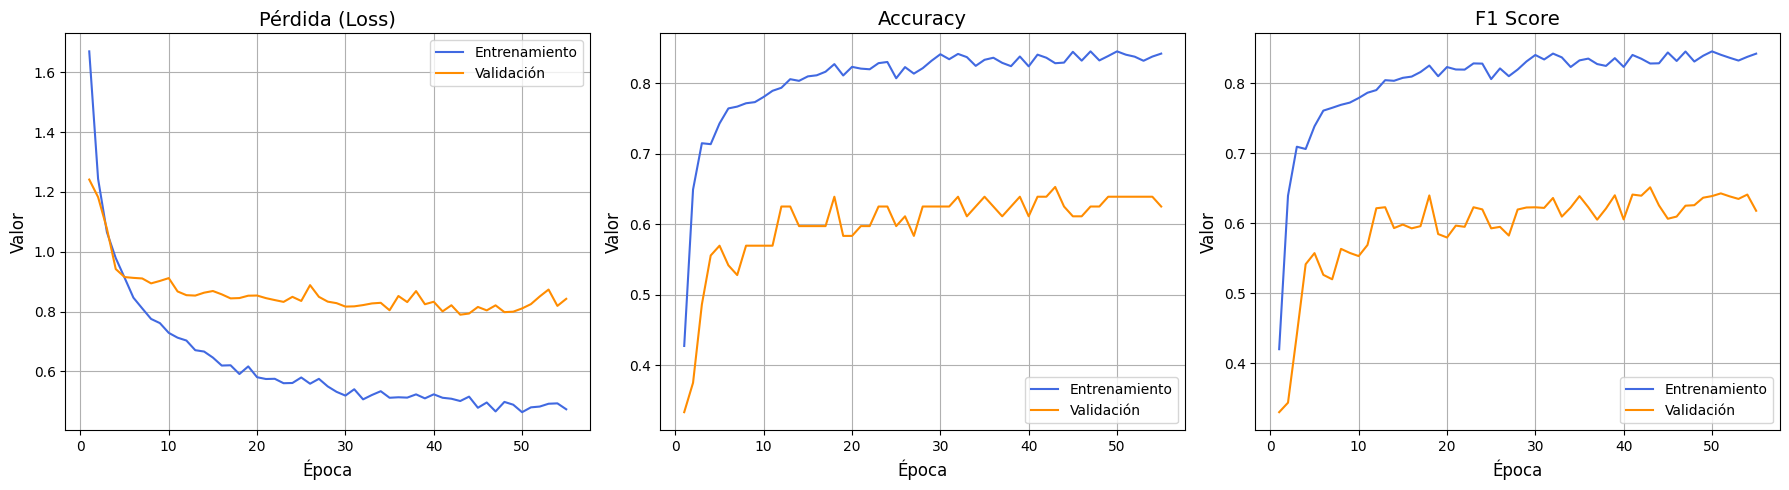

In [10]:
plot_train_results_from_json(json_file='data/inceptionv3_fc_train_results.json')

Resultados guardados en data/inceptionv3_fc_evaluation_results.json


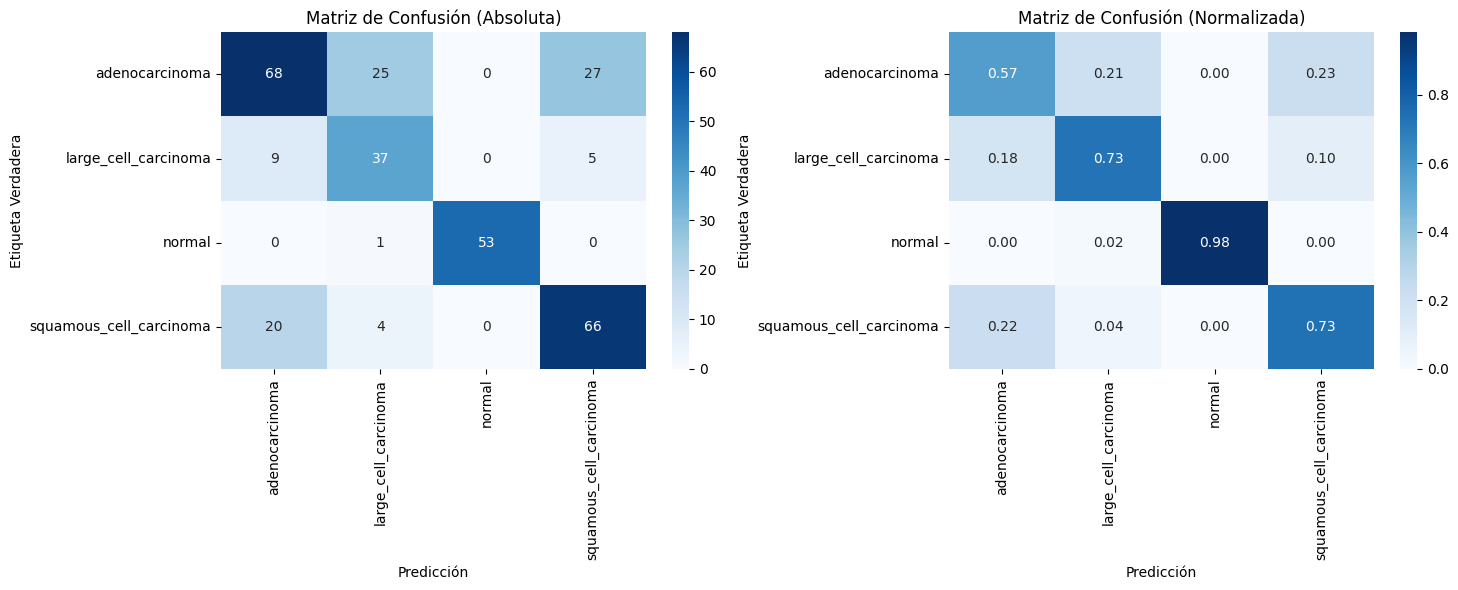

In [11]:
evaluate_model(model, test_loader, test_dataset.classes, device, output_file='data/inceptionv3_fc_evaluation_results.json')

In [12]:
model = build_inceptionv3_finetune(num_classes=4)
model = model.to(device)

# Verificación
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Entrenando: {name}")

Entrenando: AuxLogits.conv0.conv.weight
Entrenando: AuxLogits.conv0.bn.weight
Entrenando: AuxLogits.conv0.bn.bias
Entrenando: AuxLogits.conv1.conv.weight
Entrenando: AuxLogits.conv1.bn.weight
Entrenando: AuxLogits.conv1.bn.bias
Entrenando: AuxLogits.fc.weight
Entrenando: AuxLogits.fc.bias
Entrenando: Mixed_7a.branch3x3_1.conv.weight
Entrenando: Mixed_7a.branch3x3_1.bn.weight
Entrenando: Mixed_7a.branch3x3_1.bn.bias
Entrenando: Mixed_7a.branch3x3_2.conv.weight
Entrenando: Mixed_7a.branch3x3_2.bn.weight
Entrenando: Mixed_7a.branch3x3_2.bn.bias
Entrenando: Mixed_7a.branch7x7x3_1.conv.weight
Entrenando: Mixed_7a.branch7x7x3_1.bn.weight
Entrenando: Mixed_7a.branch7x7x3_1.bn.bias
Entrenando: Mixed_7a.branch7x7x3_2.conv.weight
Entrenando: Mixed_7a.branch7x7x3_2.bn.weight
Entrenando: Mixed_7a.branch7x7x3_2.bn.bias
Entrenando: Mixed_7a.branch7x7x3_3.conv.weight
Entrenando: Mixed_7a.branch7x7x3_3.bn.weight
Entrenando: Mixed_7a.branch7x7x3_3.bn.bias
Entrenando: Mixed_7a.branch7x7x3_4.conv.weight


In [13]:
fit(model, train_loader=train_loader, eval_loader=val_loader, epochs=100, model_name='data/inceptionv3_Mixed_7_fc_weights.pth', results_file='data/inceptionv3_Mixed_7_fc_train_results.json') 

val_loss 0.92950 val_acc 0.75000: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch 1/100 loss 0.48223 val_loss 0.92950 acc 0.86914 val_acc 0.75000 train_f1 0.86697 val_f1 0.74891
Mejor modelo guardado en la época 1 con val_loss 0.92950
Mejor modelo guardado.


val_loss 0.72435 val_acc 0.84722: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch 2/100 loss 0.04891 val_loss 0.72435 acc 0.99194 val_acc 0.84722 train_f1 0.99175 val_f1 0.85163
Mejor modelo guardado en la época 2 con val_loss 0.72435
Mejor modelo guardado.


val_loss 0.66746 val_acc 0.76389: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch 3/100 loss 0.03088 val_loss 0.66746 acc 0.99253 val_acc 0.76389 train_f1 0.99250 val_f1 0.76393
Mejor modelo guardado en la época 3 con val_loss 0.66746
Mejor modelo guardado.


val_loss 0.56339 val_acc 0.86111: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 4/100 loss 0.01568 val_loss 0.56339 acc 0.99556 val_acc 0.86111 train_f1 0.99575 val_f1 0.86058
Mejor modelo guardado en la época 4 con val_loss 0.56339
Mejor modelo guardado.


val_loss 0.31555 val_acc 0.93056: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch 5/100 loss 0.00995 val_loss 0.31555 acc 0.99790 val_acc 0.93056 train_f1 0.99800 val_f1 0.92966
Mejor modelo guardado en la época 5 con val_loss 0.31555
Mejor modelo guardado.


val_loss 0.43273 val_acc 0.88889: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch 6/100 loss 0.00740 val_loss 0.43273 acc 0.99756 val_acc 0.88889 train_f1 0.99750 val_f1 0.88695


val_loss 0.40878 val_acc 0.90278: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch 7/100 loss 0.00805 val_loss 0.40878 acc 0.99805 val_acc 0.90278 train_f1 0.99800 val_f1 0.90362


val_loss 0.35977 val_acc 0.94444: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch 8/100 loss 0.00512 val_loss 0.35977 acc 0.99878 val_acc 0.94444 train_f1 0.99875 val_f1 0.94639


val_loss 0.42066 val_acc 0.90278: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch 9/100 loss 0.00443 val_loss 0.42066 acc 0.99927 val_acc 0.90278 train_f1 0.99925 val_f1 0.90531


val_loss 0.53576 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch 10/100 loss 0.00704 val_loss 0.53576 acc 0.99854 val_acc 0.91667 train_f1 0.99850 val_f1 0.92056


val_loss 0.58751 val_acc 0.90278: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch 11/100 loss 0.00615 val_loss 0.58751 acc 0.99814 val_acc 0.90278 train_f1 0.99825 val_f1 0.90554


val_loss 0.62274 val_acc 0.88889: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch 12/100 loss 0.00608 val_loss 0.62274 acc 0.99839 val_acc 0.88889 train_f1 0.99850 val_f1 0.89274


val_loss 0.54389 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch 13/100 loss 0.00624 val_loss 0.54389 acc 0.99756 val_acc 0.91667 train_f1 0.99750 val_f1 0.91876


val_loss 0.56528 val_acc 0.93056: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 14/100 loss 0.00535 val_loss 0.56528 acc 0.99766 val_acc 0.93056 train_f1 0.99775 val_f1 0.93176


val_loss 0.56854 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 15/100 loss 0.00391 val_loss 0.56854 acc 0.99878 val_acc 0.91667 train_f1 0.99875 val_f1 0.92056


val_loss 0.56477 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch 16/100 loss 0.00303 val_loss 0.56477 acc 0.99839 val_acc 0.91667 train_f1 0.99850 val_f1 0.91824


val_loss 0.62790 val_acc 0.90278: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

Epoch 17/100 loss 0.00322 val_loss 0.62790 acc 0.99902 val_acc 0.90278 train_f1 0.99900 val_f1 0.90554
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([0.4822328621521592,
  0.04891164047876373,
  0.030884812586009502,
  0.015681905671954155,
  0.00995333687751554,
  0.007402178285701666,
  0.008053842568187974,
  0.005117575790791307,
  0.004429641714523314,
  0.0070385901835834375,
  0.006153060234282748,
  0.006076024825233617,
  0.0062368698927457444,
  0.005352868842237513,
  0.003910640361937112,
  0.003029496967428713,
  0.003217040648451075],
 [0.9295042753219604,
  0.7243459224700928,
  0.6674597859382629,
  0.5633869767189026,
  0.3155466318130493,
  0.4327344000339508,
  0.40877825021743774,
  0.3597714602947235,
  0.42066490650177,
  0.5357568264007568,
  0.5875074863433838,
  0.6227407455444336,
  0.5438858866691589,
  0.5652825832366943,
  0.5685351490974426,
  0.5647656917572021,
  0.6279000043869019],
 [0.869140625,
  0.991943359375,
  0.992529296875,
  0.995556640625,
  0.997900390625,
  0.99755859375,
  0.998046875,
  0.998779296875,
  0.999267578125,
  0.99853515625,
  0.99814453125,
  0.998388671875,
  0.99755859

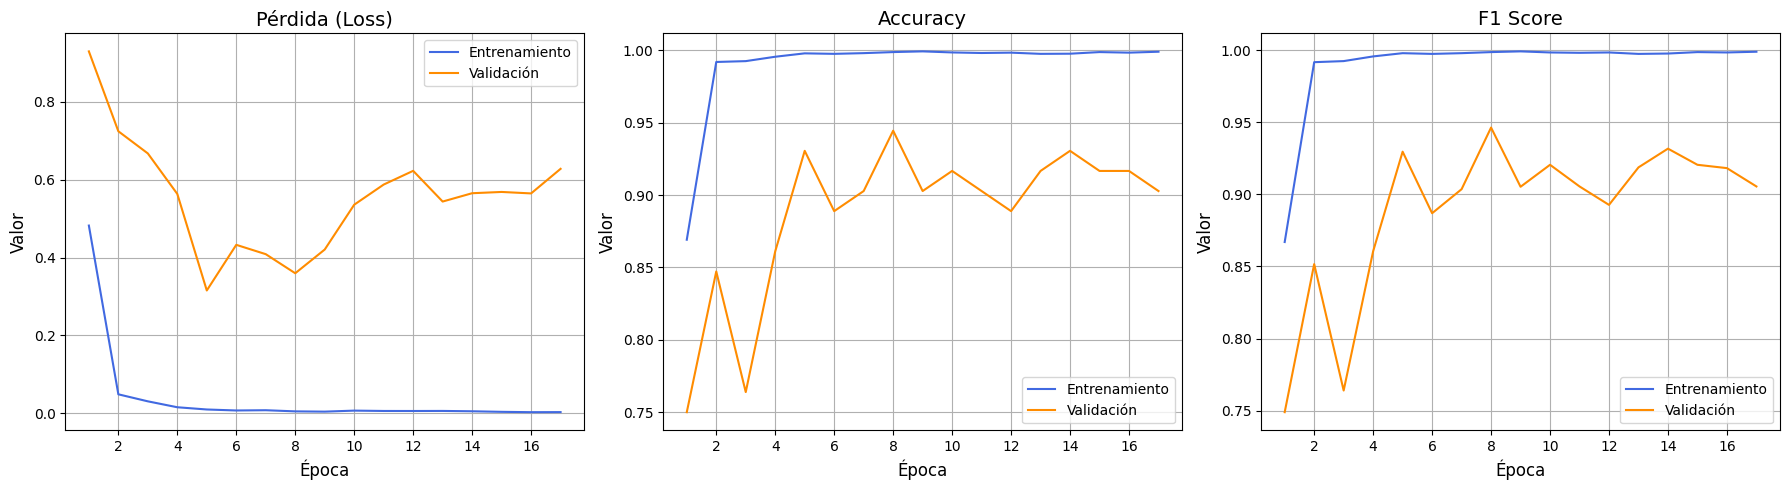

In [14]:
plot_train_results_from_json(json_file='data/inceptionv3_Mixed_7_fc_train_results.json')

Resultados guardados en data/inceptionv3_Mixed_7_fc_evaluation_results.json


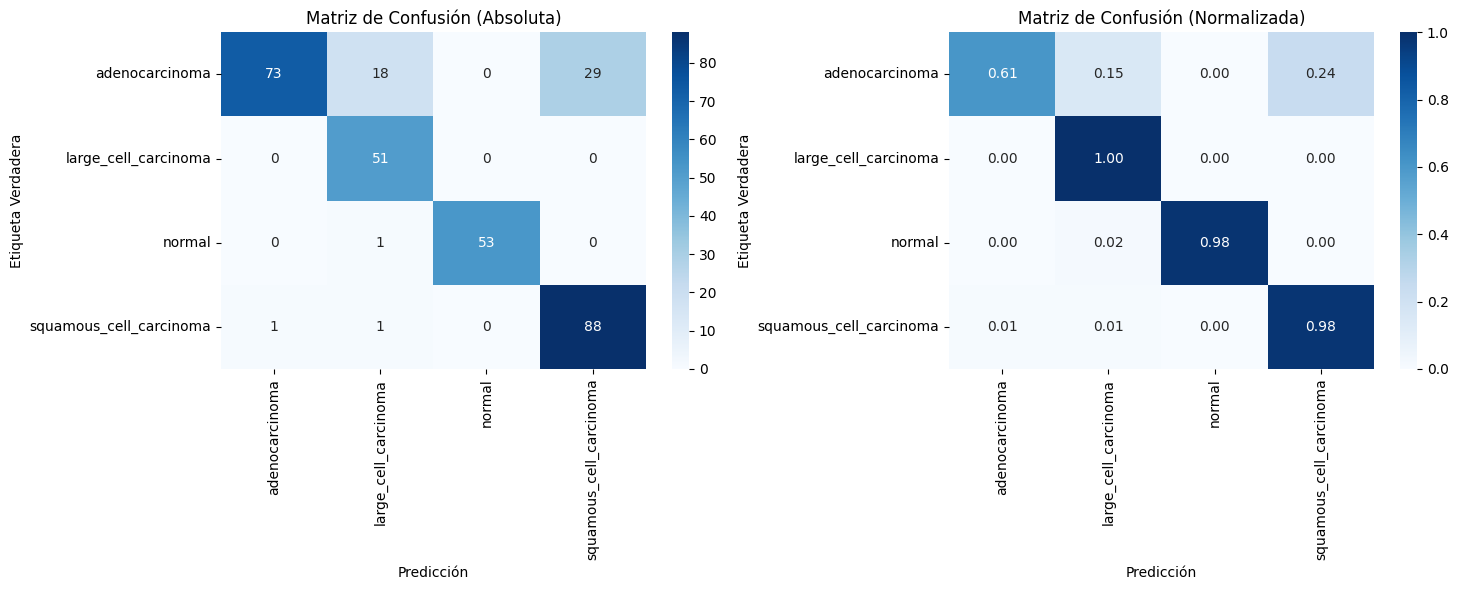

In [15]:
evaluate_model(model, test_loader, test_dataset.classes, device, output_file='data/inceptionv3_Mixed_7_fc_evaluation_results.json')